# FFTLog

This notebook is a translation of `fftlogtest.f` from the Fortran package `FFTLog`, which was presented in Appendix B of Hamilton, 2000, and published at <http://casa.colorado.edu/~ajsh/FFTLog>. It serves as an example for the python package `pyfftlog` (which is a Python version of `FFTLog`), in the same manner as the original file `fftlogtest.f` serves as an example for Fortran package `FFTLog`.


### Reference
Hamilton, A. J. S., 2000, Uncorrelated modes of the non-linear power spectrum: Monthly Notices of the Royal Astronomical Society, 312, pages 257-284; DOI: <http://dx.doi.org/10.1046/j.1365-8711.2000.03071.x>.

---

## This is fftlogtest.f

This is a simple test program to illustrate how `FFTLog` works.
The test transform is:

$$
\int^\infty_0 r^{\mu+1} \exp\left(-\frac{r^2}{2} \right)\
J_\mu(k, r)\ k\ {\rm d}r = k^{\mu+1} \exp\left(-\frac{k^2}{2}
\right) $$


**Disclaimer:**  
`FFTLog` does NOT claim to provide the most accurate possible
solution of the continuous transform (which is the stated aim
of some other codes).  Rather, `FFTLog` claims to solve the exact
discrete transform of a logarithmically-spaced periodic sequence.
If the periodic interval is wide enough, the resolution high
enough, and the function well enough behaved outside the periodic
interval, then `FFTLog` may yield a satisfactory approximation
to the continuous transform.

Observe:
1.  How the result improves as the periodic interval is enlarged.
    With the normal FFT, one is not used to ranges orders of
    magnitude wide, but this is how `FFTLog` prefers it.
2.  How the result improves as the resolution is increased.
    Because the function is rather smooth, modest resolution
    actually works quite well here.
3.  That the central part of the transform is more reliable
    than the outer parts.  Experience suggests that a good general
    strategy is to double the periodic interval over which the
    input function is defined, and then to discard the outer
    half of the transform.
4.  That the best bias exponent seems to be $q = 0$.
5.  That for the critical index $\mu = -1$, the result seems to be
    offset by a constant from the 'correct' answer.
6.  That the result grows progressively worse as mu decreases
    below -1.

The analytic integral above fails for $\mu \le -1$, but `FFTLog`
still returns answers.  Namely, `FFTLog` returns the analytic
continuation of the discrete transform.  Because of ambiguity
in the path of integration around poles, this analytic continuation
is liable to differ, for $\mu \le -1$, by a constant from the 'correct'
continuation given by the above equation.

`FFTLog` begins to have serious difficulties with aliasing as
$\mu$ decreases below $-1$, because then $r^{\mu+1} \exp(-r^2/2)$ is
far from resembling a periodic function.
You might have thought that it would help to introduce a bias
exponent $q = \mu$, or perhaps $q = \mu+1$, or more, to make the
function $a(r) = A(r) r^{-q}$ input to `fhtq` more nearly periodic.
In practice a nonzero $q$ makes things worse.

A symmetry argument lends support to the notion that the best
exponent here should be $q = 0,$ as empirically appears to be true.
The symmetry argument is that the function $r^{\mu+1} \exp(-r^2/2)$
happens to be the same as its transform $k^{\mu+1} \exp(-k^2/2)$.
If the best bias exponent were q in the forward transform, then
the best exponent would be $-q$ that in the backward transform;
but the two transforms happen to be the same in this case,
suggesting $q = -q$, hence $q = 0$.

This example illustrates that you cannot always tell just by
looking at a function what the best bias exponent $q$ should be.
You also have to look at its transform.  The best exponent $q$ is,
in a sense, the one that makes both the function and its transform
look most nearly periodic.

---

## Test-Integral:  $\int_0^\infty r^{\mu+1}\ \exp\left(-\frac{r^2}{2}\right)\ J_\mu(k,r)\ k\ {\rm d}r = k^{\mu+1} \exp\left(-\frac{k^2}{2}\right)$

### Import `pyfftlog` as well as `numpy` and `matplotlib`; some plot settings

In [1]:
import pyfftlog
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 16})

### Define the parameters you wish to use

The presets are the *Reasonable choices of parameters* from `fftlogtest.f`.

In [2]:
# Range of periodic interval
logrmin = -4
logrmax = 4

# Number of points (Max 4096)
n = 64

# Order mu of Bessel function
mu = 0

# Bias exponent: q = 0 is unbiased
q = 0

# Sensible approximate choice of k_c r_c
kr = 1

# Tell fhti to change kr to low-ringing value
# WARNING: kropt = 3 will fail, as interaction is not supported
kropt = 1

# Forward transform (changed from dir to tdir, as dir is a python fct)
tdir = 1

### Calculation related to the logarithmic spacing

In [3]:
# Central point log10(r_c) of periodic interval
logrc = (logrmin + logrmax)/2

print('Central point of periodic interval at log10(r_c) = ', logrc)

# Central index (1/2 integral if n is even)
nc = (n + 1)/2.0

# Log-spacing of points
dlogr = (logrmax - logrmin)/n
dlnr = dlogr*np.log(10.0)

Central point of periodic interval at log10(r_c) =  0.0


### Calculate input function: $r^{\mu+1}\exp\left(-\frac{r^2}{2}\right)$

In [4]:
r = 10**(logrc + (np.arange(1, n+1) - nc)*dlogr)
ar = r**(mu + 1)*np.exp(-r**2/2.0)

### Initialize FFTLog transform - note fhti resets `kr`

In [5]:
kr, xsave = pyfftlog.fhti(n, mu, dlnr, q, kr, kropt)
print('pyfftlog.fhti: new kr = ', kr)

pyfftlog.fhti: new kr =  0.953538967579


### Call `pyfftlog.fht` (or `pyfftlog.fhtl`)

In [6]:
logkc = np.log10(kr) - logrc
print('Central point in k-space at log10(k_c) = ', logkc)

# rk = r_c/k_c
rk = 10**(logrc - logkc)

# Transform
#ak = pyfftlog.fftl(ar.copy(), xsave, rk, tdir)
ak = pyfftlog.fht(ar.copy(), xsave, tdir)

Central point in k-space at log10(k_c) =  -0.0206615542605


### Calculate Output function: $k^{\mu+1}\exp\left(-\frac{k^2}{2}\right)$

In [7]:
k = 10**(logkc + (np.arange(1, n+1) - nc)*dlogr)
theo = k**(mu + 1)*np.exp(-k**2/2.0)

### Plot result

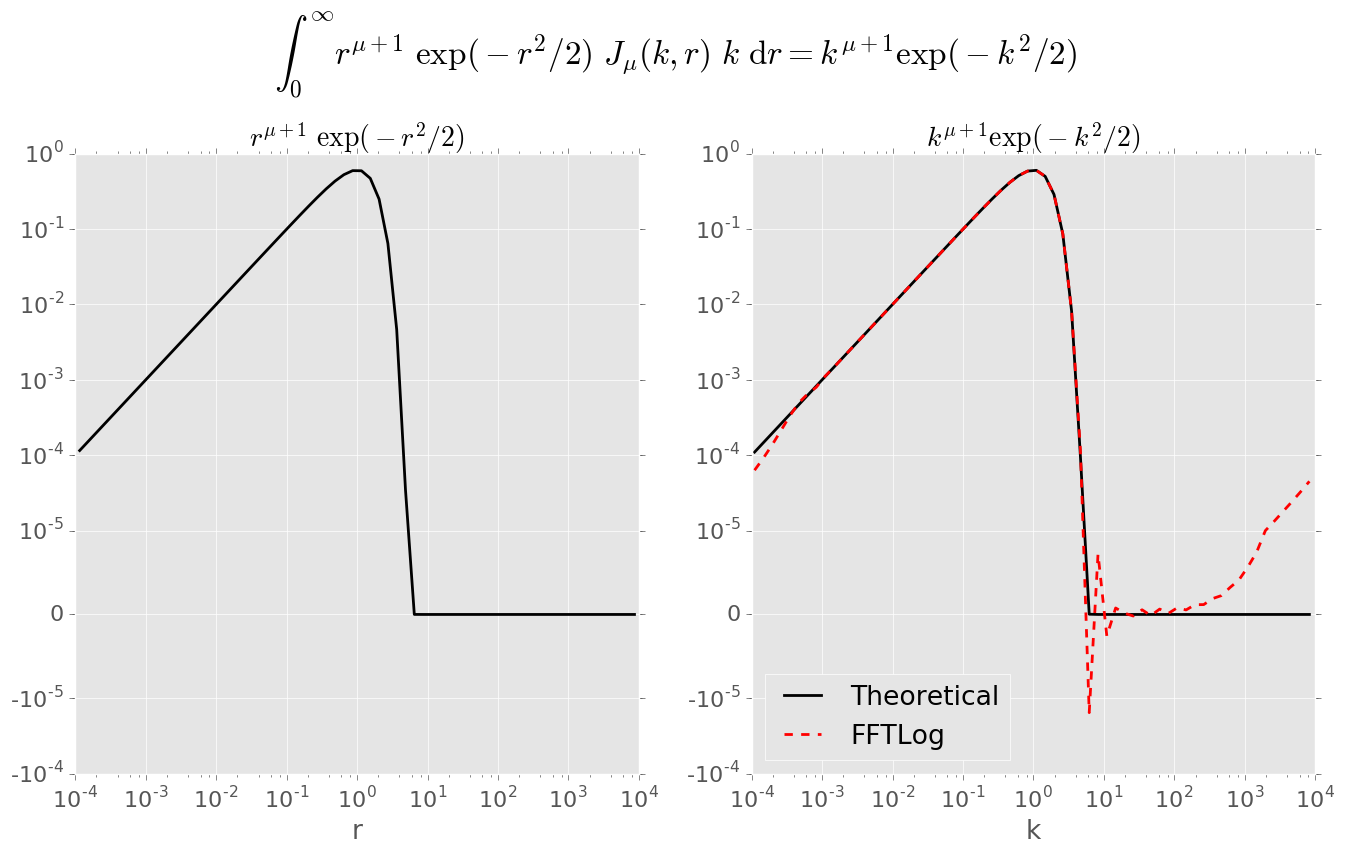

In [8]:
plt.figure(figsize=(16,8))

# Transformed result
ax2 = plt.subplot(1, 2, 2)
plt.plot(k, theo, 'k', lw=2, label='Theoretical')
plt.plot(k, ak, 'r--', lw=2, label='FFTLog')
plt.xlabel('k')
plt.title(r'$k^{\mu+1} \exp(-k^2/2)$', fontsize=20)
plt.legend(loc='best')
plt.xscale('log')
plt.yscale('symlog', basey=10, linthreshy=1e-5)
ax2ylim = plt.ylim()

# Input
ax1 = plt.subplot(1, 2, 1)
plt.plot(r, ar, 'k', lw=2)
plt.xlabel('r')
plt.title(r'$r^{\mu+1}\ \exp(-r^2/2)$', fontsize=20)
plt.xscale('log')
plt.yscale('symlog', basey=10, linthreshy=1e-5)
plt.ylim(ax2ylim)

# Main title
plt.suptitle(r'$\int_0^\infty r^{\mu+1}\ \exp(-r^2/2)\ J_\mu(k,r)\ k\ {\rm d}r = k^{\mu+1} \exp(-k^2/2)$',
             fontsize=24, y=1.08)
plt.show()

### Print values

In [9]:
print('           k                 a(k)       k^(mu+1) exp(-k^2/2)')
print('----------------------------------------------------------------')
for i in range(n):
    print("%18.6e %18.6e %18.6e"% (k[i], ak[i], theo[i]))

           k                 a(k)       k^(mu+1) exp(-k^2/2)
----------------------------------------------------------------
      1.101130e-04       6.332603e-05       1.101130e-04
      1.468380e-04       9.168618e-05       1.468380e-04
      1.958116e-04       1.374282e-04       1.958116e-04
      2.611190e-04       2.131954e-04       2.611190e-04
      3.482078e-04       3.318802e-04       3.482077e-04
      4.643425e-04       4.923984e-04       4.643425e-04
      6.192107e-04       6.460278e-04       6.192106e-04
      8.257307e-04       7.968931e-04       8.257304e-04
      1.101130e-03       1.113736e-03       1.101129e-03
      1.468380e-03       1.464233e-03       1.468378e-03
      1.958116e-03       1.959475e-03       1.958112e-03
      2.611190e-03       2.610678e-03       2.611181e-03
      3.482078e-03       3.482260e-03       3.482056e-03
      4.643425e-03       4.643299e-03       4.643375e-03
      6.192107e-03       6.191999e-03       6.191988e-03
      8.257307e-03 